In [ ]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 33.9 MB/s eta 0:00:00


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import cvxpy as cp
import scipy.linalg as la
import pulp

## how we load data from yahoo finance

In [31]:
T = 1 # Number of days in time period
R = []
assets = ["AAPL","EA","MSFT","NFLX","GOOGL","TSLA"]

for stock in assets:
    data = yf.Ticker(stock)
    # 我先改成1年， 这个之后可以随时改成想要的时段
    df = data.history(period="1y")

    # close values on that day
    close = df['Close'].values

    # convert day to day close values to return
    returns = (close[T:] - close[:-T])/close[:-T]
    R.append(returns)

R = np.array(R).T
r = np.mean(R,axis=0)
S = np.cov(R.T)

In [ ]:
R

array([[-3.24954163e-03,  3.20559871e-02, -1.74176931e-04,
        -4.39301362e-03,  3.44960338e-03, -1.12440437e-02],
       [-1.12903496e-02,  7.26610785e-03, -9.88920910e-03,
        -1.26892398e-02, -2.38731854e-03, -3.66600763e-02],
       [ 5.49591886e-03, -7.84778827e-03,  2.55329113e-02,
        -8.82143852e-03,  3.78098679e-02, -2.47955317e-03],
       ...,
       [-8.45577901e-03,  5.05011064e-03,  9.15099375e-03,
         1.14928956e-02,  3.02127678e-02, -3.24246025e-03],
       [-6.99877933e-03, -8.92457233e-03, -7.37217615e-03,
        -1.62744520e-04, -5.98114285e-03, -4.90240628e-02],
       [ 8.23264286e-03,  5.29710359e-03,  1.85079436e-03,
         2.02698600e-02,  3.23814887e-05,  1.01806147e-02]])

## tesla in past 1 years

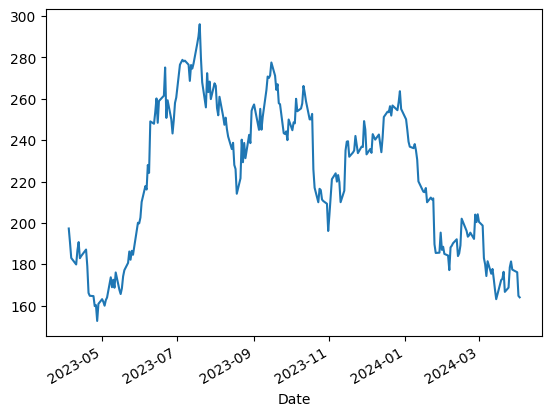

In [32]:
# last df is Tesla
df['Open'].plot()
plt.show()

## histogram of Tesla in past 1 years

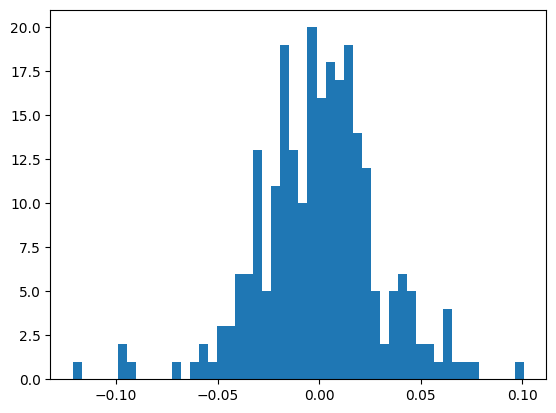

In [33]:
return_TSLA = R[:,-1]
plt.hist(return_TSLA,bins=50)
plt.show()

In [34]:
r

array([ 1.91184057e-04,  3.10699280e-04,  1.65542668e-03,  2.63376307e-03,
        1.71654716e-03, -8.73338248e-05])

In [35]:
S

array([[1.48242364e-04, 4.33191574e-05, 8.32072044e-05, 9.57739838e-05,
        9.61911623e-05, 1.34869741e-04],
       [4.33191574e-05, 1.22908715e-04, 3.64947028e-05, 3.81621620e-05,
        3.34695606e-05, 9.07951727e-05],
       [8.32072044e-05, 3.64947028e-05, 1.95019500e-04, 1.20590563e-04,
        1.03240329e-04, 1.10575145e-04],
       [9.57739838e-05, 3.81621620e-05, 1.20590563e-04, 4.99049257e-04,
        1.11351761e-04, 1.37666444e-04],
       [9.61911623e-05, 3.34695606e-05, 1.03240329e-04, 1.11351761e-04,
        2.96550175e-04, 1.35580494e-04],
       [1.34869741e-04, 9.07951727e-05, 1.10575145e-04, 1.37666444e-04,
        1.35580494e-04, 8.96514946e-04]])

# We consider risk as MAD first, all these models are model 1x




# model 1A
when we minimize MAD under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
&  \sum_j x_j r_j = r_0 \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [37]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
r0 = 0.0008
print(n,T,r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob +=  - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob += lpSum(r[j] * x[j] for j in range(n)) == r0

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


6 250 0.0008
Status: Optimal
Optimal Portfolio Weights:
x0: 0.066486142
x1: 0.60626048
x2: 0.18692331
x3: 0.052989919
x4: 0.087340151
x5: 0.0
expected return (MAD): 0.000799999999006766
Mean Absolute Deviation (MAD): 0.006742742481639993


# model 1B
when we maximize return under a specified MAD constrait $m_0$
$$
\begin{gathered}
\operatorname{maximize} \sum_j x_j r_j  \\
\text { subject to } \sum_j x_j=1 \\
  \frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \leq m_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize}  \sum_j x_j r_j   \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& \frac{1}{T} \sum_{t=1}^T y_t \leq m_0  \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [38]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
m0 = 0.007
print(n,T,r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob +=  (1/T) * lpSum(y[t] for t in range(T)) <= m0, "Risk"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


6 250 0.0008
Status: Optimal
Optimal Portfolio Weights:
x0: 0.0
x1: 0.5552795
x2: 0.23718954
x3: 0.086708929
x4: 0.12082203
x5: 0.0
expected return (MAD): 0.0010009423207007016
Mean Absolute Deviation (MAD): 0.007000000000280001


## model 1C
when combine return and risk together with $\mu$

$$
\begin{gathered}
\operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{aligned}
& \operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& x_j \geq 0 \quad j=1,2, \ldots, n \\
& y_t \geq 0 \quad t=1,2, \ldots, T . \\
&
\end{aligned}
$$

below is pulp implementation

In [ ]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
mu = 1
print(n,T,mu)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)) * mu - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


6 251 1
Status: Optimal
Optimal Portfolio Weights:
x0: 0.040958784
x1: 0.59823876
x2: 0.19432638
x3: 0.061019129
x4: 0.10545695
x5: 0.0
expected return (MAD): 0.0009366276148852837
Mean Absolute Deviation (MAD): 0.006841935690055773


# Efficient frontier

Let us use model 1B to compute the efficient frontier

In [47]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods

m0_array = np.linspace(0.0,0.01,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  # Define the data
  n = len(assets)  # Number of assets
  T = len(R[:,0])  # Number of time periods
  r0 = m0_array[i]

  # Create a LP problem
  prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

  # Define decision variables
  x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
  y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

  # Define objective function
  prob +=  - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

  # Define constraints
  for t in range(T):
      prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
      prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

  prob += lpSum(r[j] * x[j] for j in range(n)) == r0

  prob += lpSum(x) == 1, "Sum_of_weights"

  # Solve the problem
  prob.solve()
  risk_array[i] = value( (1/T) * lpSum(y[t] for t in range(T)))

#print("Status:", LpStatus[prob.status])
#print("Optimal Portfolio Weights:")
#for j in range(n):
    #print(f"x{j}: {value(x[j])}")
#print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
#print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


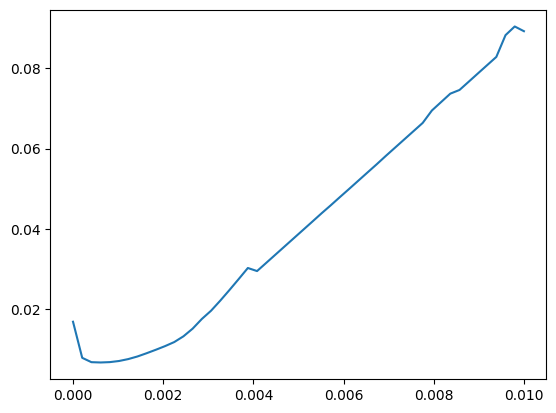

In [48]:
plt.figure()
plt.plot(m0_array, risk_array)

# Now we consider risk as total variance of the portfolio, all these models are model 2x


# model 2A
when we minimize variance under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left(\sum_j x_j\left(R_j(t)-r_j\right)\right)^2 \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

In [118]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T


r0 = 0.002
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Minimize(cp.quad_form(X,sig))
constraints = [e.T@X == 1, X >= 0, rq.T@X == r0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )


expected portfolio [[-1.03588164e-18 -1.07942848e-18  4.17186429e-01  3.36836149e-01
   2.45977423e-01 -1.10546365e-18]]
expected return : [0.002]
Mean variance: [0.00018131]
Mean std: [0.01346515]


# Model 2B

when we maximize return under a specified variance constrait $v_0$

$$
\begin{gathered}
\operatorname{maximize}  \sum_j x_j r_j  \\
\text { subject to } \sum_j x_j=1 \\
  \frac{1}{T} \sum_{t=1}^T\left(\sum_j x_j\left(R_j(t)-r_j\right)\right)^2  <= v_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$






In [122]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T


v0 = 0.0003
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Maximize(rq.T@X)
constraints = [e.T@X == 1, X >= 0, cp.quad_form(X,sig) <= v0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )


expected portfolio [[1.53039148e-07 2.03063325e-07 1.37896817e-01 6.83266980e-01
  1.78835734e-01 1.12370641e-07]]
expected return : [0.00233482]
Mean variance: [0.0003]
Mean std: [0.0173205]


## model 2C
when combine return and risk together with $\mu$

$$
\begin{gathered}
\operatorname{maximize} \mu \sum_j x_j r_j - \frac{1}{T} \sum_{t=1}^T\left(\sum_j x_j\left(R_j(t)-r_j\right)\right)^2   \\
\text { subject to } \sum_j x_j=1 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$




In [126]:
# centered return
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

mu = 0.1
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Maximize(mu * rq.T@X - cp.quad_form(X,sig))
constraints = [e.T@X == 1, X >= 0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )


expected portfolio [[-1.81032396e-23  2.37490488e-01  3.64448218e-01  1.96069799e-01
   2.01991495e-01 -3.60845445e-23]]
expected return : [0.00154023]
Mean variance: [0.00011798]
Mean std: [0.01086199]


# Efficient frontier
Let us use model 2B to compute the efficient frontier

In [139]:
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
e = np.ones((n,1))
rq = r.reshape(n,1)

m0_array = np.linspace(0.0005,0.0025,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  r0 = m0_array[i]

  X = cp.Variable((n,1))
  Objective = cp.Minimize(cp.quad_form(X,sig))
  constraints = [e.T@X == 1, X >= 0, rq.T@X == r0]
  problem = cp.Problem(Objective,constraints)

  result = problem.solve()

  risk_array[i] = (X.value.T @ sig @ X.value)[0,0]**0.5

#print("Status:", LpStatus[prob.status])
#print("Optimal Portfolio Weights:")
#for j in range(n):
    #print(f"x{j}: {value(x[j])}")
#print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
#print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


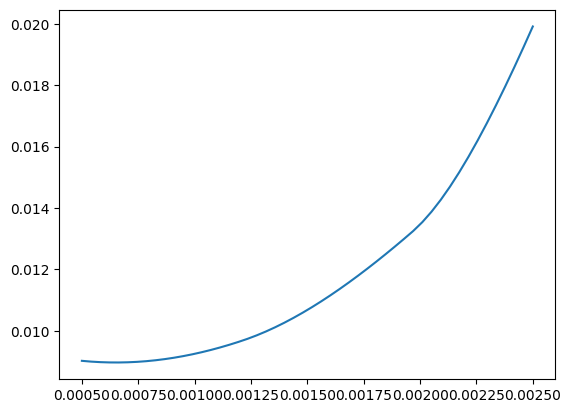

In [140]:
plt.figure()
plt.plot(m0_array, risk_array)

## Optimization Problem

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{r}^T \mathbf{x} = \mu \\
& \mathbf{x} \geq 0 \\
\end{align*}

case mu = 0.01,   minimize risk sigma = 0.001

case mu = 0.02,  minimize risk sigma = 0.003

case mu = 0.05,  minimize risk  sigma = 0.010



In [ ]:
n = len(assets)
e = np.ones((n,1))
r = r.reshape(n,1)
mu = 0.001

M = np.block([[2*S,-r,-e],[r.T,0,0],[e.T,0,0]])
b = np.block([[np.zeros((n,1))],[mu],[1]])

x = la.solve(M,b)